In [1]:
import pandas as pd
import sqlite3
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.metrics import r2_score, mean_absolute_error, explained_variance_score, mean_squared_error
conn = sqlite3.connect('/Users/Mark Rozenberg/Downloads/Macro-Indicators/macro_indicators_v2.db')

In [20]:
data = pd.read_sql_query('''
with part1 as (
select * from main_table_with_lag_v2
where irlt is not null
and share is not null and unemp is not null and wage is not null and cpi is not null and cci is not null
and lag_share is not null and lag_unemp is not null and lag_wage is not null and lag_cpi is not null and lag_cci is not null
and lag2_share is not null and lag2_unemp is not null and lag2_wage is not null and lag2_cpi is not null and lag2_cci is not null
and lag3_share is not null and lag3_unemp is not null and lag3_wage is not null and lag3_cpi is not null and lag3_cci is not null
and cast(substr(time_period, 1, 4) as int) between 2005 and 2023
),
part2 as(
select country, count(distinct time_period) as num_periods
from part1
group by 1
)
select *
from part1
where country in(select country from part2 where num_periods = 228)
''', conn)

In [21]:
# Extract month from time_period and create dummies
data['month'] = pd.to_datetime(data['time_period']).dt.month
month_dummies = pd.get_dummies(data['month'], prefix='month')

# Concatenate the dummies with the original dataframe
data = pd.concat([data, month_dummies], axis=1)

# Drop the original month column as it's no longer needed
data.drop('month', axis=1, inplace=True)

data.head()

,country,time_period,irlt,share,unemp,wage,cpi,cci,lag_share,lag_unemp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,BGR,2005-01,4.48,138.8700,10.8,35.93628,3.329007,-17.7,133.8769,10.6,...,False,False,False,False,False,False,False,False,False,False
1,BGR,2005-02,4.21,163.6629,10.3,37.54143,3.862976,-18.4,138.8700,10.8,...,False,False,False,False,False,False,False,False,False,False
2,BGR,2005-03,4.17,182.5630,9.8,35.96231,4.278162,-16.7,163.6629,10.3,...,True,False,False,False,False,False,False,False,False,False
3,BGR,2005-04,4.16,169.9412,9.3,37.60123,5.104789,-18.8,182.5630,9.8,...,False,True,False,False,False,False,False,False,False,False
4,BGR,2005-05,4.16,168.5633,8.8,41.00221,4.569630,-14.0,169.9412,9.3,...,False,False,True,False,False,False,False,False,False,False


In [22]:
data.dtypes

country         object
time_period     object
irlt           float64
share          float64
unemp          float64
wage           float64
cpi            float64
cci            float64
lag_share      float64
lag_unemp      float64
lag_wage       float64
lag_cpi        float64
lag_cci        float64
lag2_share     float64
lag2_unemp     float64
lag2_wage      float64
lag2_cpi       float64
lag2_cci       float64
lag3_share     float64
lag3_unemp     float64
lag3_wage      float64
lag3_cpi       float64
lag3_cci       float64
month_1           bool
month_2           bool
month_3           bool
month_4           bool
month_5           bool
month_6           bool
month_7           bool
month_8           bool
month_9           bool
month_10          bool
month_11          bool
month_12          bool
dtype: object

In [23]:
data['time_period'] = pd.to_datetime(data['time_period'])

In [24]:
# Ensure your data is in a panel data format
data.set_index(['time_period'], inplace=True)

In [25]:
data.head()

,country,irlt,share,unemp,wage,cpi,cci,lag_share,lag_unemp,lag_wage,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
time_period,,,,,,,,,,,,,,,,,,,,,
2005-01-01,BGR,4.48,138.8700,10.8,35.93628,3.329007,-17.7,133.8769,10.6,38.93257,...,False,False,False,False,False,False,False,False,False,False
2005-02-01,BGR,4.21,163.6629,10.3,37.54143,3.862976,-18.4,138.8700,10.8,35.93628,...,False,False,False,False,False,False,False,False,False,False
2005-03-01,BGR,4.17,182.5630,9.8,35.96231,4.278162,-16.7,163.6629,10.3,37.54143,...,True,False,False,False,False,False,False,False,False,False
2005-04-01,BGR,4.16,169.9412,9.3,37.60123,5.104789,-18.8,182.5630,9.8,35.96231,...,False,True,False,False,False,False,False,False,False,False
2005-05-01,BGR,4.16,168.5633,8.8,41.00221,4.569630,-14.0,169.9412,9.3,37.60123,...,False,False,True,False,False,False,False,False,False,False


In [26]:
data.columns

Index(['country', 'irlt', 'share', 'unemp', 'wage', 'cpi', 'cci', 'lag_share',
       'lag_unemp', 'lag_wage', 'lag_cpi', 'lag_cci', 'lag2_share',
       'lag2_unemp', 'lag2_wage', 'lag2_cpi', 'lag2_cci', 'lag3_share',
       'lag3_unemp', 'lag3_wage', 'lag3_cpi', 'lag3_cci', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

### Model Version 1

In [31]:
# Define the model
model_v1 = MixedLM.from_formula('irlt ~ share + unemp + wage + cpi + cci + \
lag_share + lag_unemp + lag_wage + lag_cpi + lag_cci + \
lag2_share + lag2_unemp + lag2_wage + lag2_cpi + lag2_cci + \
lag3_share + lag3_unemp + lag3_wage + lag3_cpi + lag3_cci', 
                             groups='country', 
                             data=data)

# Fit the model
result = model_v1.fit()
# result.summary()
# Make predictions
data['predictions_v1'] = result.predict(data)

### Model Version 2

In [27]:
# Define the model
model_v2 = MixedLM.from_formula('irlt ~ share + unemp + wage + cpi + cci + \
unemp * wage + wage * cpi + cci * share + \
month_1 + month_2 + month_3 + month_4 + month_5 + month_6 + month_7 + month_8 + month_9 + month_10 + month_11 + month_12', 
                             groups='country', 
                             data=data)

# Fit the model
result = model_v2.fit()
# result.summary()
# Make predictions
data['predictions_v2'] = result.predict(data)

c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
c:\Users\Mark Rozenberg\LTINT-Forecast\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelih

In [33]:
# this table will hold the testing metrics from the various models
Compare_Table = pd.DataFrame(columns=['Model','MAE','MSE','EVS','COD'])

In [ ]:
# Filter data for USA
usa_data = data[data['country'] == 'USA']
# Sort the data by time_period index
usa_data.sort_index(inplace=True)
usa_data_split = usa_data.loc['2020-02':'2023-12']
y_test = usa_data_split['irlt']
forec_Mod5 = usa_data_split['predictions_v1']
new_row = pd.DataFrame([{'Model': 'Mixed Effects - Panel Data Model - V1',
                                      'MAE':mean_absolute_error(y_test, forec_Mod5),
                                      'MSE':mean_squared_error(y_test, forec_Mod5),
                                      'EVS':explained_variance_score(y_test, forec_Mod5),
                                      'COD':r2_score(y_test, forec_Mod5)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)
forec_Mod6 = usa_data_split['predictions_v2']
new_row = pd.DataFrame([{'Model': 'Mixed Effects - Panel Data Model - V2',
                                      'MAE':mean_absolute_error(y_test, forec_Mod6),
                                      'MSE':mean_squared_error(y_test, forec_Mod6),
                                      'EVS':explained_variance_score(y_test, forec_Mod6),
                                      'COD':r2_score(y_test, forec_Mod6)}])
Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)
Compare_Table

C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_15160\674234255.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usa_data.sort_index(inplace=True)
C:\Users\Mark Rozenberg\AppData\Local\Temp\ipykernel_15160\674234255.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Compare_Table = pd.concat([Compare_Table, new_row], ignore_index=True)


,Model,MAE,MSE,EVS,COD
0,Mixed Effects - Panel Data Model - V1,1.81611,4.883069,0.068921,-1.868809
1,Mixed Effects - Panel Data Model - V1,2.98792,10.313226,0.185983,-5.059034


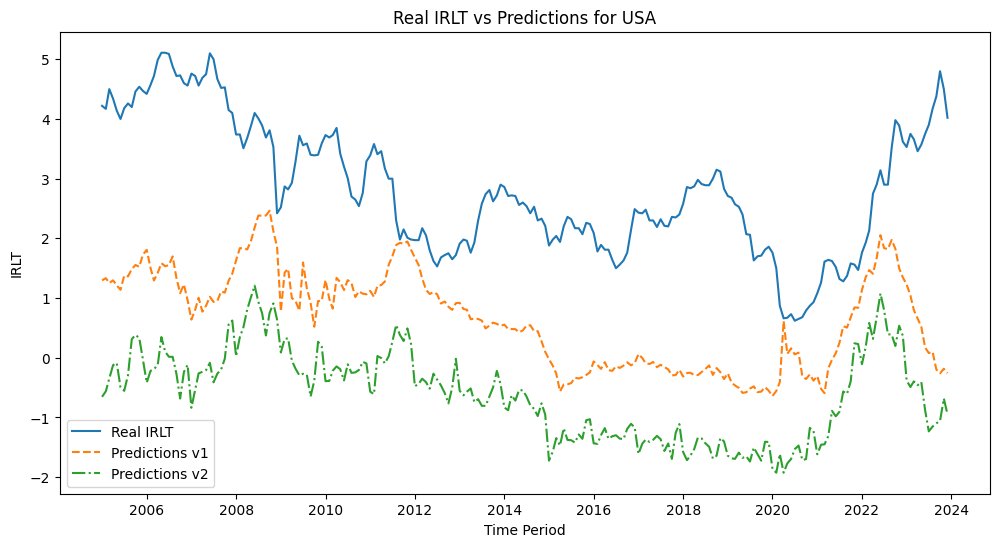

In [36]:
import matplotlib.pyplot as plt
# Plot real irlt and predictions
plt.figure(figsize=(12, 6))
plt.plot(usa_data.index, usa_data['irlt'], label='Real IRLT')
plt.plot(usa_data.index, usa_data['predictions_v1'], label='Predictions v1', linestyle='--')
plt.plot(usa_data.index, usa_data['predictions_v2'], label='Predictions v2', linestyle='-.')
plt.xlabel('Time Period')
plt.ylabel('IRLT')
plt.title('Real IRLT vs Predictions for USA')
plt.legend()
plt.show()